# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

print(len(train_loader))
print(len(val_loader))

308
76


In [3]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN_Long.ckpt"),WIDTH=32,HEIGHT=7)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [5]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


KeyboardInterrupt: 

---

### Get Raw Activations

In [6]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output),dim=0)



model.gnn.conv[-1].register_forward_hook(append_raw_activations)



In [6]:
# Acquire the activations
raw_activations = torch.zeros(0,32)
predictions = torch.zeros(0)
ground = torch.zeros(0)
for batch in train_loader:
    num_elems = batch.x.shape[0]
    predictions = torch.cat([predictions,torch.zeros(num_elems)+model(batch.x,batch.edge_index,batch.batch).argmax()])
    ground = torch.cat([ground,(torch.zeros(num_elems)+batch.y)])

predictions = torch.as_tensor(predictions)
ground = torch.as_tensor(ground)
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [7]:
print(raw_activations.shape)

torch.Size([280840, 32])


In [8]:
assert raw_activations.shape[0] == predictions.shape[0]

---
# K Means

In [7]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters


In [18]:

from scipy.cluster.vq import kmeans
import numpy as np
k = 10

tsne_size = 3000

obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)


def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means,_ = kmeans(obs_white,k_or_guess=k)

clusters = cluster(obs_white,means,k)
print(list(map(len,clusters)))

np.random.seed(7)
subset = np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)
obs = obs[subset]
obs_white = whiten(obs)

clusters = cluster(obs_white,means,k)


[99476, 59692, 224600, 171012, 146552, 64440, 53952, 73828, 161720, 68088]


In [26]:
print(list(map(len,clusters)))

[259, 153, 597, 490, 388, 180, 132, 199, 409, 193]


---
# Vizualize Explanations

In [27]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',init="pca",verbose=2,perplexity = 1000,n_iter=1000).fit_transform(obs_white)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

[t-SNE] Computing 2999 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.931180
[t-SNE] Computed conditional probabilities in 2.281s


d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 41.5538101, gradient norm = 0.0001219 (50 iterations in 4.082s)
[t-SNE] Iteration 100: error = 41.5577583, gradient norm = 0.0000005 (50 iterations in 3.938s)
[t-SNE] Iteration 150: error = 41.5577583, gradient norm = 0.0000006 (50 iterations in 3.825s)
[t-SNE] Iteration 200: error = 41.5577583, gradient norm = 0.0000003 (50 iterations in 3.720s)
[t-SNE] Iteration 250: error = 41.5577583, gradient norm = 0.0000006 (50 iterations in 3.714s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.557758
[t-SNE] Iteration 300: error = 0.9753914, gradient norm = 0.0000006 (50 iterations in 3.800s)
[t-SNE] Iteration 350: error = 0.2028909, gradient norm = 0.0006617 (50 iterations in 3.954s)
[t-SNE] Iteration 400: error = 0.1922402, gradient norm = 0.0001319 (50 iterations in 3.944s)
[t-SNE] Iteration 450: error = 0.1910614, gradient norm = 0.0001391 (50 iterations in 3.882s)
[t-SNE] Iteration 500: error = 0.1867415, gradient norm = 0.0000770 (50 

In [28]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_concept_clusters(cluster_ids,values):
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
    plt.show()

def plot_cancer_clusters(cancer_type,values):
    colours = cm.rainbow(np.linspace(0,1,4))
    for i in range(4):
        nodes_with_cancer_type = (cancer_type==i)
        v = values[nodes_with_cancer_type]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
        plt.show()

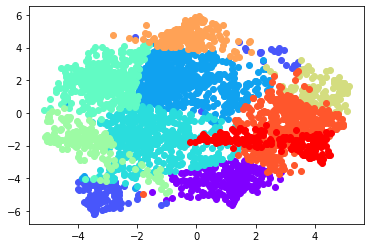

NameError: name 'predictions' is not defined

In [29]:
plot_concept_clusters(clusters,t) # clusters and t must be whitened
plot_cancer_clusters(predictions[subset],t)

---
# Concept Completeness

In [8]:
# Activation Graph to Concept Graph


# Attach the hook

activations = []

def save_activation_graph(self, input, output):
    global activations
    activations.append(output)



model.gnn.conv[-1].register_forward_hook(save_activation_graph)



In [9]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_concept_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return activation_to_concept_graph(ag,means,k)



In [17]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data

def vizualize_concept_graph(graph,means,k):
    print(graph.y)
    x = predict_concept_graph(graph,means,k)
    edge_index  = graph.edge_index
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(graph,to_undirected=True)

    f,ax = plt.subplots(1,1,figsize=(70,70))
    nx.draw(G,pos=pos,node_color=node_colours,node_size=500)
    plt.show()

tensor([1])


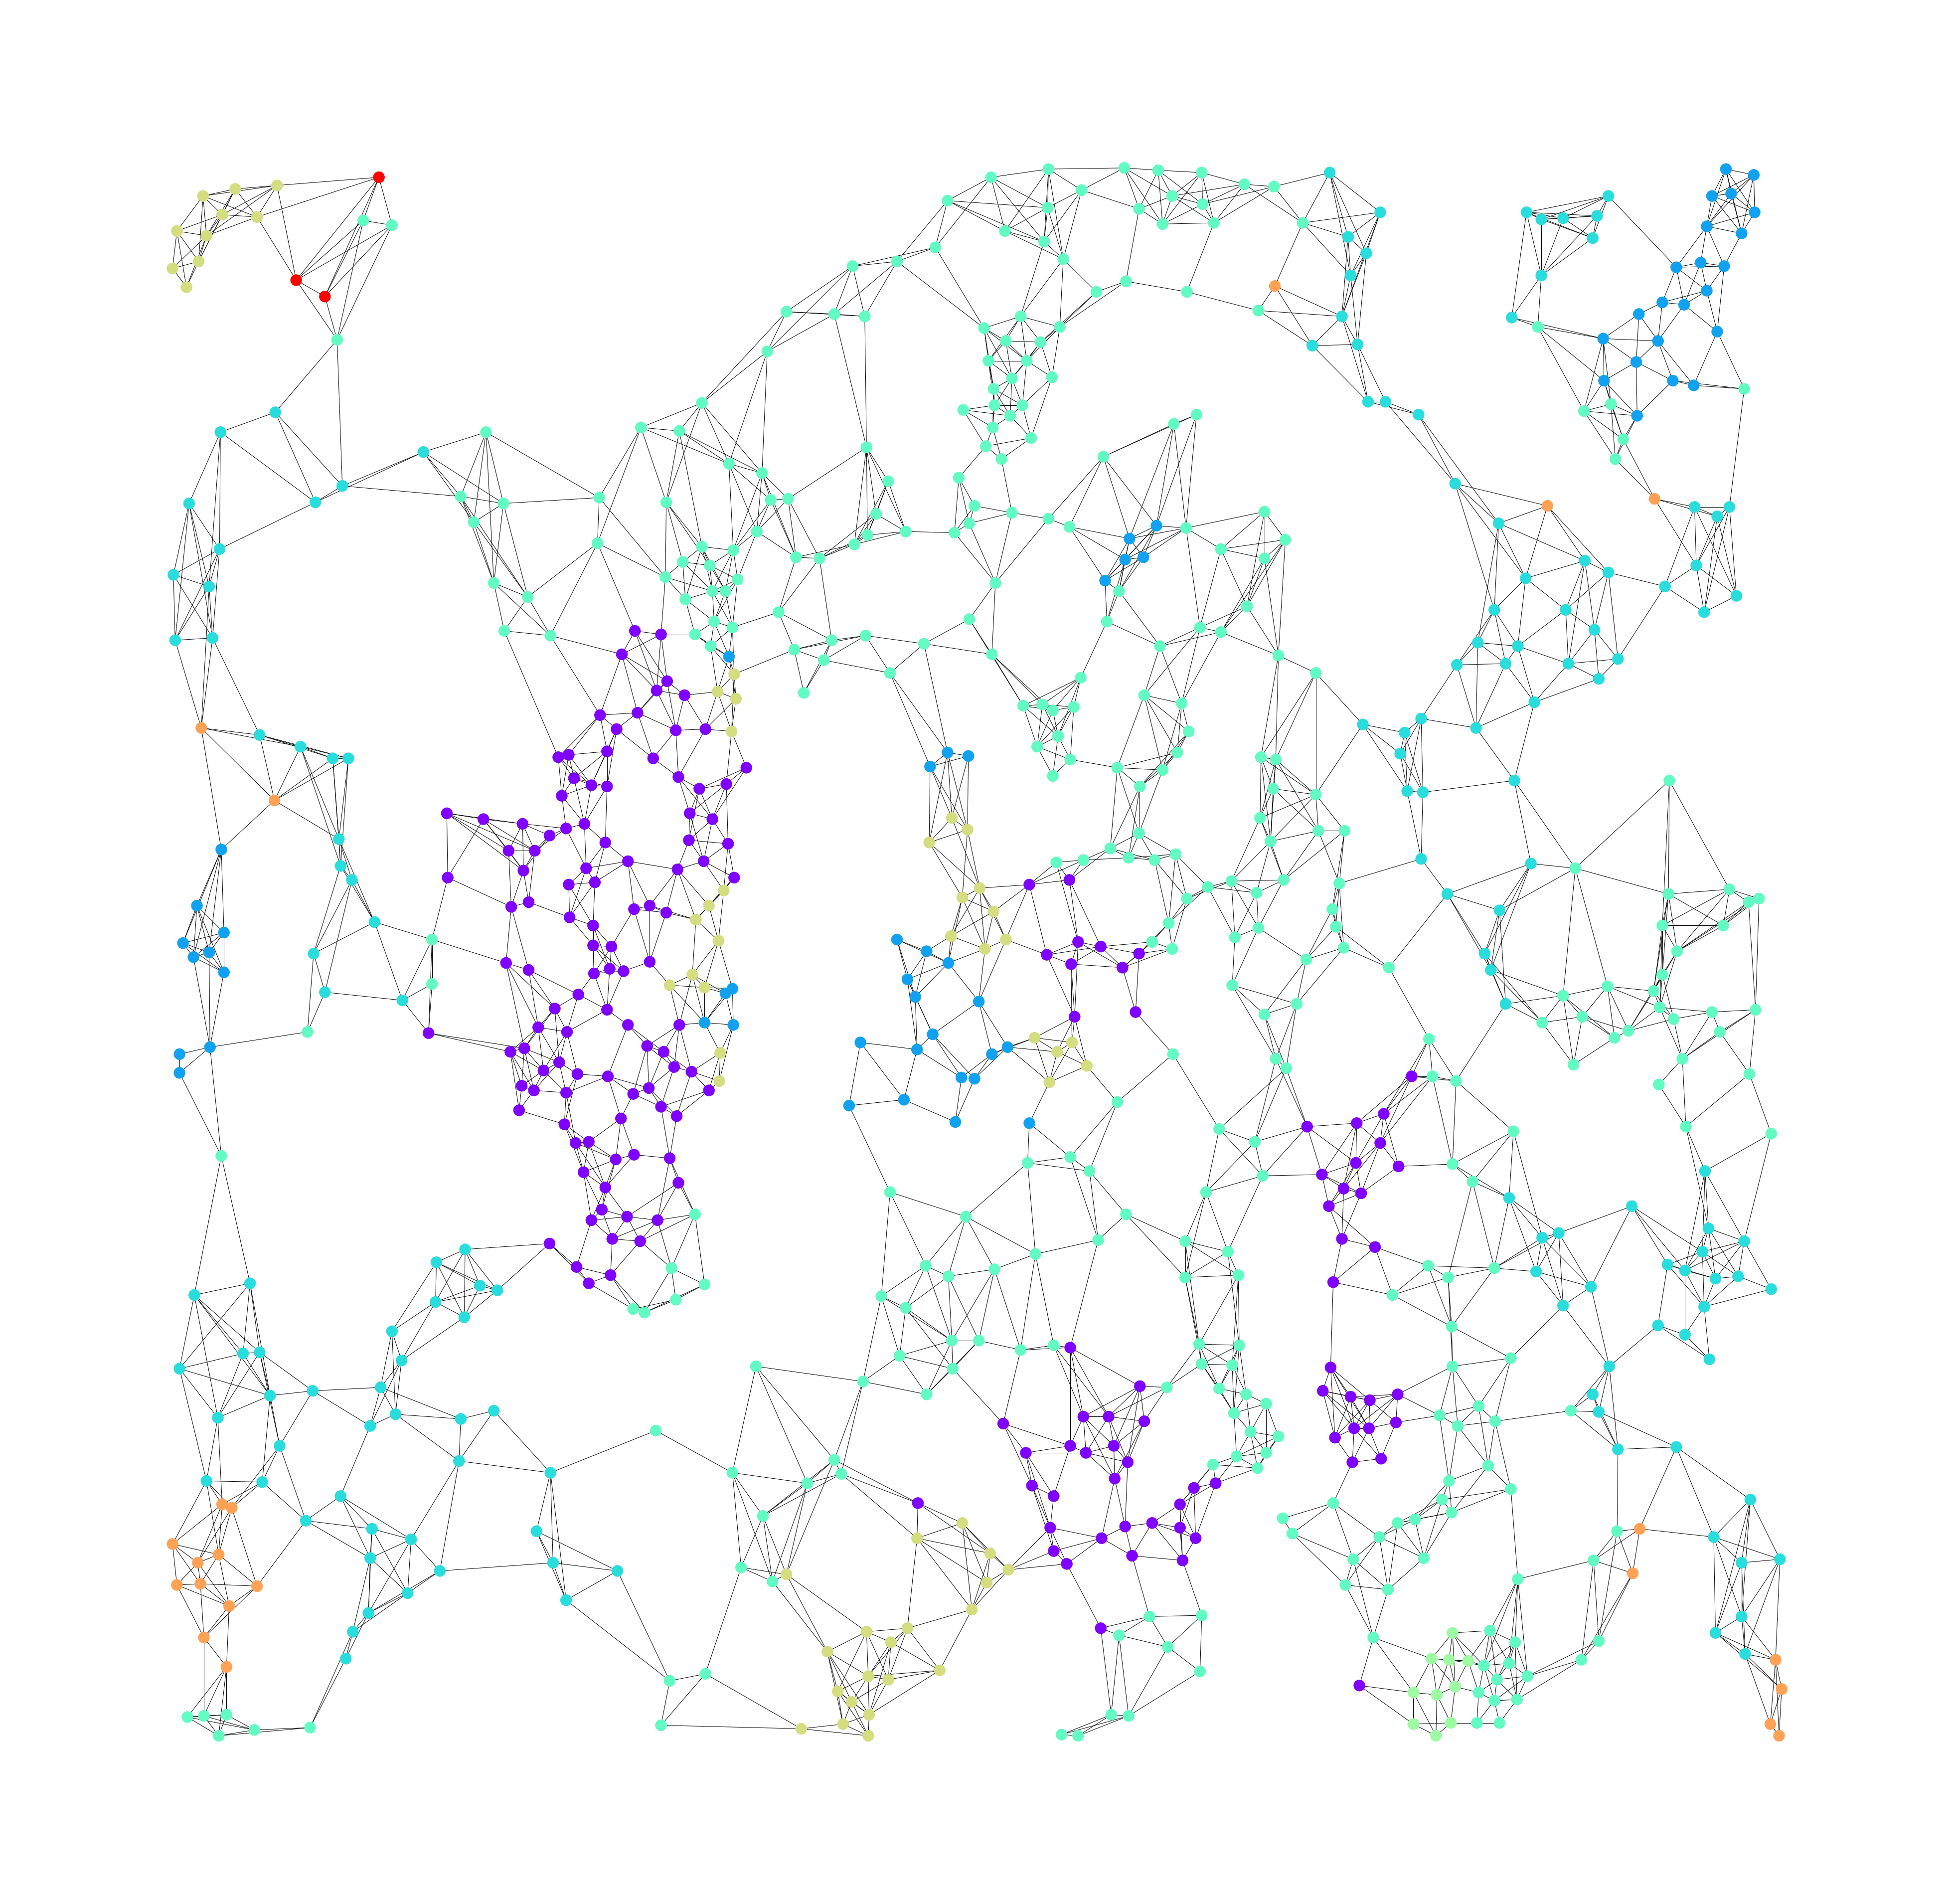

In [18]:
vizualize_concept_graph(next(iter(val_loader)),means,k)

---

In [21]:
def concept_vs_cancer(loader): return [(predict_concept_graph(batch.means,k).mean(dim=0),batch.y) for batch in loader]

In [20]:
x_train = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader))))
y_train = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader))))

x_val = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader))))
y_val = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader))))

TypeError: predict_concept_graph() missing 2 required positional arguments: 'means' and 'k'

In [ ]:
def plot_agg_concept_for_class(cls,x,y):
    f = plt.figure(figsize=(20,10))
    ind = y==cls
    assert len(x) == len(y)

    plt.imshow(x[ind].reshape(k,-1))


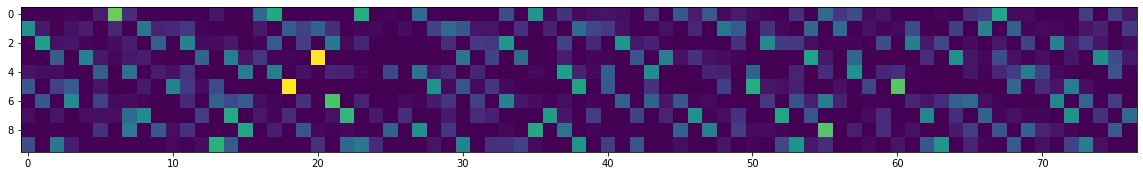

In [ ]:
plot_agg_concept_for_class(1,x_train,y_train)

In [ ]:
torch.as_tensor(x_train).max(dim=0)

torch.return_types.max(
values=tensor([0.8511, 1.0000, 0.7043, 1.0000, 0.9171, 0.7425, 1.0000, 0.8686, 0.8182,
        0.8448], dtype=torch.float64),
indices=tensor([263,  96, 215, 111,  62, 265,  13,  67, 211, 280]))

In [19]:
X_train = torch.zeros(0,k)
Y_train = torch.zeros(0)

for graph in train_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    x = predict_concept_graph(graph,means,k)
    X_train = torch.cat([X_train,x],dim=0)
    Y_train = torch.cat([Y_train,y],dim=0)

In [40]:
len(X_train),len(Y_train),(Y_train==3).sum()

(280840, 280840, tensor(83773))

In [ ]:
X_val = torch.zeros(0,k)
Y_val = torch.zeros(0)

for graph in val_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    x = predict_concept_graph(graph)
    X_val = torch.cat([X_val,x],dim=0)
    Y_val = torch.cat([Y_val,y],dim=0)

In [ ]:
print((Y_val<=1))

tensor([ True,  True,  True,  ..., False, False, False])


---
### CBE

0.5187864976499075


NameError: name 'X_val' is not defined

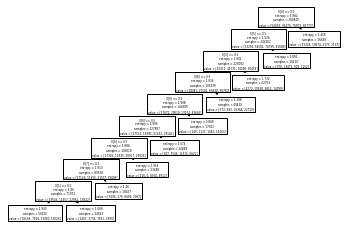

In [51]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree

l = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train,Y_train)

tree.plot_tree(l)

print(l.score(X_train,Y_train))
print(l.score(X_val,Y_val))



In [47]:
# See P(class|concept)
from tqdm import tqdm
from torch.nn.functional import normalize


def class_concept_joint_frequency(CLS,CONCEPT):
    class_concept = torch.zeros(4,k)
    for cons,cl in tqdm(zip(CONCEPT,CLS)):
        class_concept[cl.int(),cons.argmax()] += 1
    return class_concept
    

In [69]:

def class_condition_concepts_prob(joint_freq,concepts): # concepts in one_hot_form
    output = torch.zeros(4)
    joint_freq+=1
    def _p_class(cl): return joint_freq[cl].sum()/joint_freq.sum()
    def _p_concept(cons): return joint_freq[:,cons].sum()/joint_freq.sum()
    def _p_concept_given_class(cons,cl): return joint_freq[cl,cons]/joint_freq[cl].sum()
    for cl in range(4):
        tot = torch.log(_p_class(cl))
        for cons in concepts:
            cons = cons.argmax()
            tot  += torch.log(_p_concept_given_class(cons,cl))
            tot -= torch.log(_p_concept(cons))
        output[cl] = tot
    return output       
        
    

In [71]:
freq = class_concept_joint_frequency(Y_train,X_train)

280840it [00:06, 42906.05it/s]


In [85]:
class_condition_concepts_prob(freq,X_train[0:10000])

tensor([ 5744.1938, -3880.6199, -4815.1177, -6355.6714])

In [ ]:
from torch.nn.functional import normalize

z = normalize(class_to_concept,dim=1,p=1)
y = torch.zeros(k,2)
y[:,0] = z[:,0]+z[:,1]
y[:,1] = z[:,2]+z[:,3]
y

tensor([[0.0347, 0.9653],
        [0.3072, 0.6928],
        [0.0153, 0.9847],
        [0.8986, 0.1014],
        [0.4099, 0.5901],
        [0.5658, 0.4342],
        [0.4942, 0.5058],
        [0.8989, 0.1011],
        [0.3482, 0.6518],
        [0.0751, 0.9249]])

In [ ]:
z

tensor([[0.0110, 0.0237, 0.4047, 0.5606],
        [0.0075, 0.2998, 0.4629, 0.2299],
        [0.0153, 0.0000, 0.6259, 0.3588],
        [0.0567, 0.8418, 0.0303, 0.0711],
        [0.4002, 0.0097, 0.4748, 0.1153],
        [0.1022, 0.4637, 0.1109, 0.3233],
        [0.3410, 0.1532, 0.2538, 0.2520],
        [0.5935, 0.3054, 0.0481, 0.0530],
        [0.0987, 0.2495, 0.5245, 0.1273],
        [0.0083, 0.0668, 0.0981, 0.8268]])

---
# Deducing K


1) Choose K
2) Get Convert list of graphs to list of (activation, graph id)
3) Get list (graph_id, ground_truth, pred_truth)
4) Generate means and hence concepts from activations
5) Get concepts from activations
6) Use decision tree to predict (concept-> cancer_type)
7) Evaluate how accurate
8) **Define concept prevelance score** and evaluate. If below certain threshold
9) Increment K and plot.

In [91]:
from tqdm import tqdm

def first(x): return x[0]
def second(x): return x[1]
def third(x): return x[2]


# todo FIX!

def deduce_k(train_loader,val_loader,model,max_k=60):
    global activations
    ks = []
    dt_scores = []
    concept_accs = []
    for k in range(4,max_k,4):
        #1
        act_graph = []
        graph_gt_pred = []
        #2 & 3
        for i,graph in tqdm(enumerate(train_loader),total=len(train_loader)):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            act_graph += [(act, i) for act in activations[0]]
            graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        graph_gt_pred = sorted(graph_gt_pred)
        
        
        val_act_graph = []
        val_graph_gt_pred = []
        #2 & 3
        for i,graph in tqdm(enumerate(val_loader),total=len(val_loader)):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            val_act_graph += [(act, i) for act in activations[0]]
            val_graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        val_graph_gt_pred = sorted(val_graph_gt_pred)
        
        
        
        
        #4
        
        obs = torch.stack(list(map(lambda x:x[0],act_graph))).numpy()
        obs_white = whiten(obs)
        means,_ = kmeans(obs_white,k_or_guess=k)
        clusters = cluster(obs_white,means,k)
        
        #5
        concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),act_graph)) # DO NOT FORGET TO WHITEN
        concepts_by_graph = [torch.stack([c[0] for c in concepts_graph if c[1]==g]) for g in range(len(graph_gt_pred))]
        
        val_concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),val_act_graph)) # DO NOT FORGET TO WHITEN
        val_concepts_by_graph = [torch.stack([c[0] for c in val_concepts_graph if c[1]==g]) for g in range(len(val_graph_gt_pred))]
        
        #6
        concepts = torch.stack(list(map(first,concepts_graph)))
        classes = torch.as_tensor(list(map(lambda x:graph_gt_pred[x[1]][1].item(),concepts_graph)))
        
        val_concepts = torch.stack(list(map(first,val_concepts_graph)))
        val_classes = torch.as_tensor(list(map(lambda x:val_graph_gt_pred[x[1]][1].item(),val_concepts_graph)))
        
        dt = tree.DecisionTreeClassifier(criterion="entropy").fit(concepts.numpy(),classes.numpy())
        
        
        #6.5
        
        joint_freq = class_concept_joint_frequency(classes,concepts)
        val_concept_pred = torch.as_tensor(list(map(lambda i: class_condition_concepts_prob(joint_freq,val_concepts_by_graph[i]).argmax(), range(len(val_graph_gt_pred)))))
        gt = torch.as_tensor(list(map(second,val_graph_gt_pred)))
        pred = torch.as_tensor(list(map(third,val_graph_gt_pred)))
        
        concept_acc = (val_concept_pred==gt).sum()/len(gt)
        
        #7
        ks += [k]
        dt_scores += [dt.score(val_concepts.numpy(),val_classes.numpy())]
        concept_accs += [concept_acc]
        
    return ks,dt_scores,concept_acc
        
ks,dts,concept_acc = deduce_k(train_loader,val_loader,model,max_k=5)

 39%|███▊      | 119/308 [00:23<00:36,  5.20it/s]

In [ ]:
plt.plot(ks,dts)
plt.plot(ks,concept_acc)
plt.show()